## **Basic libraries and Pytorch**

ในบทเรียนนี้เราจะลองนำภาพจากชุดข้อมูล Dog breed classification มาทดลอง Image augmentation และสร้าง Convolutional Neural Network (CNN) อย่างง่ายกัน


วิธีการโหลดของข้อมูลจาก Kaggle:

```
!pip install kaggle
!kaggle competitions download -c dog-breed-identification
!unzip dog-breed-identification.zip -d data
```

In [1]:
import os.path as op
import torch
import pandas as pd
from glob import glob

In [2]:
img_df = pd.DataFrame(glob("data/train/*.jpg"), columns=["path"])
img_df["id"] = img_df.path.map(lambda x: op.basename(x).replace(".jpg", ""))

# read label data
label_df = pd.read_csv("data/labels.csv")
train_df = img_df.merge(label_df, on="id")

In [3]:
train_df.head()

,path,id,breed
0,data/train/e8afeaf121012b3abbac531f126c198f.jpg,e8afeaf121012b3abbac531f126c198f,bull_mastiff
1,data/train/145f7bb3bf6e4877b8b6624f612a1c24.jpg,145f7bb3bf6e4877b8b6624f612a1c24,doberman
2,data/train/29b06acb65e3873dfab2a7b2581d6a35.jpg,29b06acb65e3873dfab2a7b2581d6a35,toy_poodle
3,data/train/9e14a1584d8ee8447ff5f71896fca8a8.jpg,9e14a1584d8ee8447ff5f71896fca8a8,welsh_springer_spaniel
4,data/train/0b86485ef980b0b4999e7ede1f90999e.jpg,0b86485ef980b0b4999e7ede1f90999e,great_dane


In [4]:
# ไลบรารี่ PIL สามารถโหลดและโชว์ภาพได้ดังด้านล่าง
from PIL import Image

In [5]:
img = Image.open(train_df.path.iloc[0])

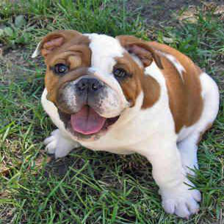

In [6]:
img.resize((224, 224)) # resize ภาพให้เป็นขนาด 224 x 224

## **Image augmentation**

Image augmentation เป็นหนึ่งในการนำภาพที่มีอยู่มาปรับแต่งเล็กน้อยเพื่อให้ได้ภาพที่มีความหลากหลายมากยิ่งขึ้น ส่วนมากการใช้ Image augmentation มาใช้ในโมเดลจะทำให้โมเดลสามารถเรียนรู้ได้ดียิ่งขึ้นอีกด้วย และลดการ overfit ของชุดข้อมูลที่เราใส่เข้าไปได้

### ไลบรารี่ augmentation ที่เป็นที่นิยมได้แก่
- `torchvision` (อ่านเพิ่มเติมได้ที่ https://pytorch.org/vision/stable/transforms.html)
- `albumentations` (อ่านเพิ่มเติมได้ที่ https://albumentations.ai/docs/)

In [7]:
import torchvision.transforms as T

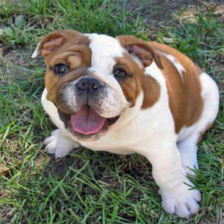

In [8]:
transform = T.Resize((224, 224))
transform(img)

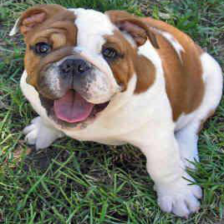

In [9]:
transform = T.RandomResizedCrop((224, 224), scale=(0.3, 1.2))
transform(img)

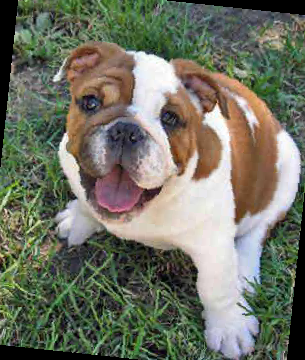

In [10]:
transform = T.RandomRotation(20)
transform(img)

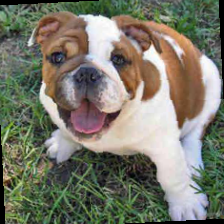

In [11]:
transforms = T.Compose([
    T.RandomResizedCrop((224, 224), scale=(0.5, 1.2)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10)
])
transforms(img)

## **Convolutional Neural Network (CNN)**

Convolutional Neural Network (CNN) เป็นหนึ่งใน backbone ที่สำคัญของการใช้ Deep learning ในการประมวลผลภาพ ในหัวข้อนี้เราจะมาลองสร้าง CNN ของไลบรารี่ Pytorch กัน

### Key Take away:

- เราสามารถสร้าง layer ได้ด้วย class `nn.Module`, `nn.Conv2d`
- โมเดลของ Pytorch รับภาพใน dimension ดังนี้ `(batch size, depth, width, height)`
- วิธีการคำนวณขนาดของภาพหลังจากผ่าน Convolutional layer: `(((W - K + 2P)/S) + 1)` โดย W = ขนาดของภาพ, K = kernel size, S = stride, P = Padding (reference: https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer)


Reference:
- https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
transforms = T.Compose([
    T.RandomResizedCrop((224, 224), scale=(0.5, 1.2)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor()
])

In [14]:
img_t = transforms(img)
img_t.shape

torch.Size([3, 224, 224])

In [15]:
img_tb = img_t.unsqueeze(0)
img_tb.shape

torch.Size([1, 3, 224, 224])

In [16]:
# ทดลองสร้าง Convolutional layer ที่รับ input depth = 3, output = 16, kernel size = 3, padding = 1
conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)

In [17]:
img_t = conv1(img_tb)
img_t.shape

torch.Size([1, 16, 224, 224])

In [18]:
# ทดลองสร้าง pooling 
pool = nn.MaxPool2d(2, 2)

In [19]:
img_t = pool(img_t)
img_t.shape

torch.Size([1, 16, 112, 112])

In [20]:
img_t = img_t.view(-1, 16 * 112 * 112)
img_t.shape

torch.Size([1, 200704])

In [21]:
32 * 56 * 56

100352

In [22]:
class CNN(nn.Module):
    """
    Class ของ Convolutional layer ที่รับ input ภาพขนาด 3 x 224 x 224
    
    หน้าตาของโมเดล
    image --> [conv1 --> pool --> conv2 --> pool --> linear] --> output
    
    ขนาด input ของภาพ: (batchsize, 3, 224, 224)
    ขนาดของ output: (batchsize, 120) # ทำนาย logits ของพันธุ์หมา
    """
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(100352, 120)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        return x

In [23]:
cnn_model = CNN()

In [24]:
img_t = transforms(img)
img_t = img_t.unsqueeze(0)
img_t.shape

torch.Size([1, 3, 224, 224])

In [25]:
logits = cnn_model(img_t)

In [26]:
logits.shape

torch.Size([1, 120])

In [27]:
# เปลี่ยนจาก logits เป็นความน่าจะเป็น
F.softmax(logits, dim=1)

tensor([[0.0080, 0.0083, 0.0093, 0.0080, 0.0080, 0.0080, 0.0090, 0.0095, 0.0080,
         0.0080, 0.0088, 0.0085, 0.0080, 0.0087, 0.0092, 0.0090, 0.0080, 0.0082,
         0.0103, 0.0089, 0.0080, 0.0080, 0.0087, 0.0080, 0.0081, 0.0080, 0.0083,
         0.0080, 0.0080, 0.0080, 0.0100, 0.0081, 0.0080, 0.0082, 0.0085, 0.0080,
         0.0080, 0.0080, 0.0094, 0.0089, 0.0087, 0.0084, 0.0080, 0.0080, 0.0081,
         0.0080, 0.0080, 0.0091, 0.0083, 0.0088, 0.0080, 0.0086, 0.0095, 0.0080,
         0.0087, 0.0080, 0.0080, 0.0080, 0.0087, 0.0080, 0.0080, 0.0095, 0.0080,
         0.0087, 0.0080, 0.0080, 0.0080, 0.0090, 0.0080, 0.0080, 0.0080, 0.0080,
         0.0083, 0.0084, 0.0080, 0.0087, 0.0080, 0.0089, 0.0080, 0.0082, 0.0080,
         0.0087, 0.0080, 0.0080, 0.0092, 0.0080, 0.0080, 0.0080, 0.0085, 0.0089,
         0.0091, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0094,
         0.0080, 0.0092, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0082, 0.0080,
         0.0092, 0.0080, 0.0